In [2]:
from pynq import Overlay
from time import sleep
import numpy as np
from matplotlib import pyplot as plt
from os import path
%matplotlib inline

In [17]:
class TestChip(Overlay):
    """TestChip class is the main driver
    class for interacting with our FPGA bitstream
    Coded by: Uncle Arash
    Version: 0.0
    """
    def __init__(self, ol_path, **kwargs):
        super().__init__(ol_path)
        self.heater_base_address = 0x00000000
        self.RO_base_address = 0x00000000
        self.BTI_base_write_address = 0x00000000
        self.BTI_base_read_address = 0x00000004
        self.temp_sensor_address = 0x200
        self.counter_address_increament = 0x04
        self.num_oscillators = 31
        self.num_BTI = 31
        self.intensity_dict = {i: int(sum(
                                          [2**j for j in range(i)])
                                      ) for i in range(1, 33)
                               }
        self.intensity_dict[0] = 0
        for key, value in kwargs.items():
            if "heater_base_address" in key:
                self.heater_base_address = value
            if "counter_base_address" in key:
                self.counter_base_address = value
            if "num_oscillators" in key:
                self.num_oscillators = value
            if "counter_address_increament" in key:
                self.counter_address_increament = value
            if "temp_sensor_address" in key:
                self.temp_sensor_address = value
        self._a = 4.07548611   # 5
        self._b = 0.50103761   # 50
        self.temp_ctrl_sensitivity = 2
        self.temp_ctrl_intensity = 0

    def XADC_temp(self):
        return ((self.Temp_sensor.read(self.temp_sensor_address
                                       ) >> 4) * 503.975/4096 - 273.15)

    def freq2temp(self, Δf):
        """The values of a and b are for 5 stage ROs in ZYNQ 7000"""
        return Δf * self._a + self._b

    def read_RO(self, RO_list):
        """Reads the frequency of selected ROs
        Parameters:
        RO_list (list of int): list of ROs whose values we read

        Returns: freq_list (nparray)
        """
        len_ro = len(RO_list)
        freq_list = np.zeros((len_ro, 1))
        for i in range(len_ro):
            assert RO_list[i] <= self.num_oscillators
            freq_list[i] = self.RO.read(
                                self.RO_base_address +
                                i*self.counter_address_increament
                                        )/1000
        return freq_list

    def read_BTI(self, BTI_list):
        """Reads the frequency of selected BTI sensort
        Parameters:
        BTI_list (list of int): list of BTI sensors whose values we read

        Returns: freq_list (nparray)
        """
        len_ro = len(BTI_list)
        freq_list = np.zeros((len_ro, 1))
        for i in range(len_ro):
            assert BTI_list[i] <= self.num_BTI
            #   Putting the BTI sensors into the counting mode
            self.BTI.write(self.BTI_base_write_address, self.intensity_dict[i])
            freq_list[i] = self.BTI.read(
                                self.BTI_base_read_address +
                                i * self.counter_address_increament
                                        )/1000
            #   Putting the BTI sensors back into the aging mode
            self.BTI.write(self.BTI_base_write_address, 0)
        return freq_list

    def record(self, step_size, number_of_samples, output_name):
        """Records all of the ROs, BTI sensor data and the XADC temperature
           and saves them to a numpy array

        Parameters:
        step_size (float): seconds
        number_of_samples (int): total number of samples to be recorded
        output_name (str): outputfile_name

        Returns: None
        """
        output = np.zeros((number_of_samples,
                           self.num_BTI + self.num_oscillators + 1))
        for i in range(number_of_samples):
            output[i, self.num_BTI+self.num_oscillators] = self.XADC_temp()
            # Reading RO values in MHz
            for j in range(self.num_oscillators):
                output[i, j] = (
                                self.RO.read(
                                            self.RO_base_address +
                                            j * self.counter_address_increament
                                                    ) / 1000
                                )
            # Reading BTI values in MHz
            for j in range(self.num_BTI):
                #   Putting the BTI sensors into the counting mode
                self.BTI.write(self.BTI_base_write_address,
                               self.intensity_dict[i])
                output[i, j] = (
                                self.BTI.read(
                                            self.BTI_base_read_address +
                                            j * self.counter_address_increament
                                                    ) / 1000
                                )
                #   Putting the BTI sensors back into the aging mode
                self.BTI.write(self.BTI_base_write_address,
                               self.intensity_dict[i])
        if path.exists(output_name+'.npy'):
            old_output = np.load(output_name+'.npy')
            output = np.concatenate((old_output, output), axis=0)
        np.save(output_name+'.npy', output)
        return output

    def top_region_heat_on(self, intensity):
        """Turns the top region heat on
        top region heat, heats up the whole top region of the chip

        Parameters:
        intensity (int): intensity of the heat
        (the final temperature depends on ventilation
        and/or isolation of the chip)
        intensity has to be between 0 to 64

        Returns: None
        """

        if intensity > 64:
            intensity = 64
        elif intensity < 0:
            intensity = 0

        if intensity < 33:
            lsb_heater = self.intensity_dict[intensity]
            msb_heater = 0x00000000
        else:
            lsb_heater = 0xFFFFFFFF
            msb_heater = self.intensity_dict[intensity-32]

        self.heater.write(self.heater_base_address, lsb_heater)
        self.heater.write(self.heater_base_address+0x04, msb_heater)

    def top_region_heat_off(self):
        """Turns the top region heat off
        top region heat, heats up the whole top region of the chip

        Returns: None
        """

        self.heater.write(self.heater_base_address, 0x00000000)
        self.heater.write(self.heater_base_address+0x04, 0x00000000)

    def fix_temperature(self, desired_temperature):
        """simple control scheme to fix the temperature to a desired value

        Returns: None
        """

        if self.XADC_temp() > (desired_temperature +
                               self.temp_ctrl_sensitivity):
            self.temp_ctrl_intensity -= 1
            self.top_region_heat_on(self.temp_ctrl_intensity)
        elif self.XADC_temp() < (desired_temperature -
                                 self.temp_ctrl_sensitivity):
            self.temp_ctrl_intensity += 1
            self.top_region_heat_on(self.temp_ctrl_intensity)
        if self.temp_ctrl_intensity > 64:
            self.temp_ctrl_intensity = 64
        elif self.temp_ctrl_intensity < 0:
            self.temp_ctrl_intensity = 0

    def __str__(self):
        return (f"Number of ROs: {self.num_oscillators}; "
                "Current temperature: {self.XADC_temp()}; "
                "Number of BTIs: {self.num_BTI}")

In [12]:
ol = TestChip('/home/xilinx/pynq/overlays/RO/RO.bit')

In [13]:
ol.RO.read

In [34]:
%%time
temperature = []
for j in range(7000):
    temperature.append(ol.XADC_temp())
    sleep(0.1)
    if j < 250:
        ol.fix_temperature(55)
    if 500 > j > 250:
        ol.fix_temperature(90)
    if j > 500:
        ol.fix_temperature(120)
ol.top_region_heat_off()

CPU times: user 4min 7s, sys: 22.5 s, total: 4min 29s
Wall time: 18min 58s


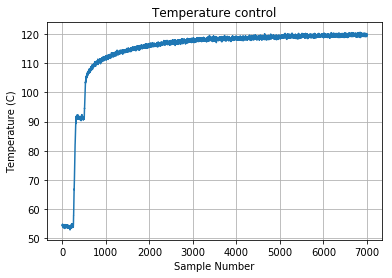

In [35]:
fig, ax = plt.subplots()
ax.plot(temperature)

ax.set(xlabel='Sample Number', ylabel='Temperature (C)',
       title='Temperature control')
ax.grid()

fig.savefig("Temperature_control2.png", dpi=300)
plt.show()

In [8]:
%%time
temperature = []
for intensity in range(64):
    ol.top_region_heat_on(intensity)
    for j in range(500):
        temperature.append(ol.XADC_temp())
        sleep(0.1)
ol.top_region_heat_off()


CPU times: user 4min 53s, sys: 28.5 s, total: 5min 21s
Wall time: 1h 30s


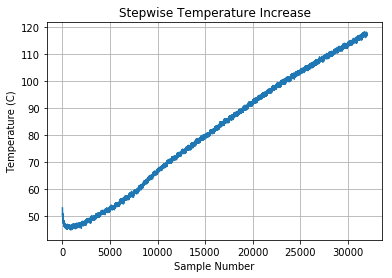

In [14]:
fig, ax = plt.subplots()
ax.plot(temperature)

ax.set(xlabel='Sample Number', ylabel='Temperature (C)',
       title='Stepwise Temperature Increase')
ax.grid()

fig.savefig("Temperature_curve.png", dpi=300)
plt.show()

In [10]:
ol.top_region_heat_off()


In [37]:
max(temperature)

120.70350952148442

In [14]:
ol = Overlay('/home/xilinx/pynq/overlays/base/base.bit')

In [6]:
ol = Overlay('/home/xilinx/pynq/overlays/RO/RO.bit')

In [7]:
ol?

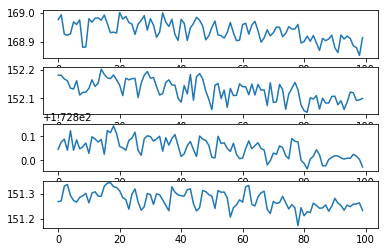

In [84]:
duration = 100
output = ol.record(0.1, duration, f'3stageRO')
fig, axs = plt.subplots(4)
axs[0].plot(output[:,0])
axs[1].plot(output[:,1])
axs[2].plot(output[:,2])
axs[3].plot(output[:,3])

In [85]:
sleep(20)

In [6]:
ol = TestChip('/home/xilinx/pynq/overlays/RO/RO3.bit')

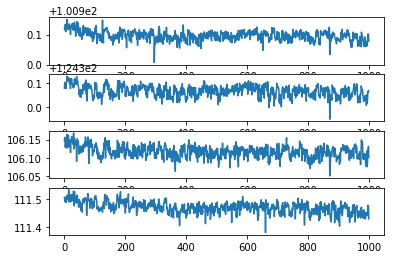

In [7]:
duration = 1000
output = ol.record(0.1, duration, f'RO_A1')
fig, axs = plt.subplots(4)
axs[0].plot(output[:,0])
axs[1].plot(output[:,1])
axs[2].plot(output[:,2])
axs[3].plot(output[:,3])

In [8]:
sleep(20)

In [9]:
ol = TestChip('/home/xilinx/pynq/overlays/RO/RO4.bit')

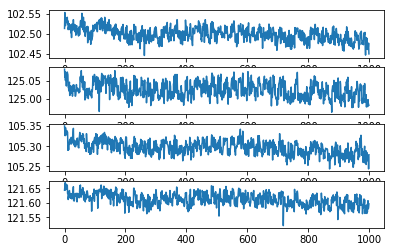

In [10]:
duration = 1000
output = ol.record(0.1, duration, f'R')
fig, axs = plt.subplots(4)
axs[0].plot(output[:,0])
axs[1].plot(output[:,1])
axs[2].plot(output[:,2])
axs[3].plot(output[:,3])

In [80]:
for i in range(5):
    ol.top_region_heat_on(i)
    duration = 100
    if i == 4:
        duration = 100
    output = ol.record(0.1, duration, f'5stagetemp')
    print(ol)
ol.top_region_heat_off()

Number of ROs: 4; Current temperature: 43.926068115234386
Number of ROs: 4; Current temperature: 55.61494140625001
Number of ROs: 4; Current temperature: 68.1651000976563
Number of ROs: 4; Current temperature: 83.79127807617192
Number of ROs: 4; Current temperature: 95.84927368164068


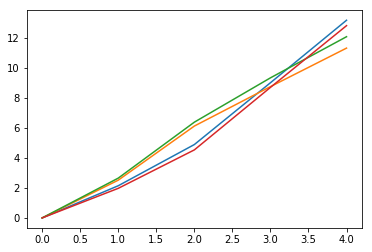

In [83]:
plt.plot([(np.mean(output[50:100,3]) - np.mean(output[i:i+50,3])) for i in [50,120,220,320,420]])
plt.plot([(np.mean(output[50:100,2]) - np.mean(output[i:i+50,2])) for i in [50,120,220,320,420]])
plt.plot([(np.mean(output[50:100,1]) - np.mean(output[i:i+50,1])) for i in [50,120,220,320,420]])
plt.plot([(np.mean(output[50:100,0]) - np.mean(output[i:i+50,0])) for i in [50,120,220,320,420]])

In [75]:
print(ol.freq2temp(12.792259999999999))

113.9613


In [69]:
np.polyfit([0.0,2.140540000000044,4.881680000000017,8.992880000000042,13.151980000000009, 0.0,2.512080000000026,6.111620000000016,8.735359999999986,11.298200000000008], [0.0, 9.90724291992187,22.632119506835934,37.64801525878907, 50.14895764160157,0.0, 9.90724291992187,22.632119506835934,37.64801525878907, 50.14895764160157], deg = 1)

array([4.07548611, 0.50103761])

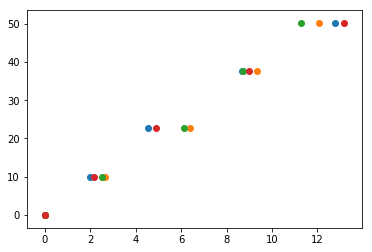

In [82]:
for j in range(0,4):
    plt.scatter([(np.mean(output[50:100,j]) - np.mean(output[i:i+50,j])) for i in [50,120,220,320,420]], [( np.mean(output[i:i+50,4])- np.mean(output[50:100,4])) for i in [50,120,220,320,420]])

In [74]:
[(np.mean(output[50:100,0])-np.mean(output[i:i+50,0])) for i in [50,120,220,320,420]]

[0.0,
 1.968500000000006,
 4.525880000000001,
 8.684059999999988,
 12.792259999999999]

In [87]:
for i in range(32):
    print(f'[{(i+1)*32-1}:{i*32}]')

[31:0]
[63:32]
[95:64]
[127:96]
[159:128]
[191:160]
[223:192]
[255:224]
[287:256]
[319:288]
[351:320]
[383:352]
[415:384]
[447:416]
[479:448]
[511:480]
[543:512]
[575:544]
[607:576]
[639:608]
[671:640]
[703:672]
[735:704]
[767:736]
[799:768]
[831:800]
[863:832]
[895:864]
[927:896]
[959:928]
[991:960]
[1023:992]


In [10]:
np.zeros((5,1)).shape

(5, 1)